In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

df = pd.read_csv("dataset_E408.csv")

df.head()

,datetime,PM10,PM2.5,temperature,rain,pressure,precipitation,wind_speed,clouds,wind_direction
0,2024-05-02 20:00:00,6.0,3.0,14.0,1.5,1007.0,76.0,6.0,oblačno,NaN
1,2024-05-02 21:00:00,4.0,2.0,12.0,0.5,1007.0,81.0,1.0,oblačno,NaN
2,2024-05-02 22:00:00,6.0,2.0,12.0,0.8,1007.0,88.0,2.0,oblačno,NaN
3,2024-05-02 23:00:00,6.0,3.0,11.0,0.0,1007.0,76.0,1.0,pretežno oblačno,NaN
4,2024-05-03 00:00:00,6.0,3.0,10.0,0.0,1007.0,85.0,1.0,pretežno oblačno,NaN


In [14]:
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.sort_values("datetime")
df = df.set_index("datetime")

df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14100 entries, 2024-05-02 20:00:00 to 2025-12-11 07:00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PM10            13921 non-null  float64
 1   PM2.5           13921 non-null  float64
 2   temperature     13885 non-null  float64
 3   rain            13885 non-null  float64
 4   pressure        13870 non-null  float64
 5   precipitation   13885 non-null  float64
 6   wind_speed      13885 non-null  float64
 7   clouds          13885 non-null  object 
 8   wind_direction  7168 non-null   object 
dtypes: float64(7), object(2)
memory usage: 1.1+ MB


In [15]:
df.index.to_series().diff().value_counts().head()


,count
datetime,
0 days 01:00:00,14099


In [16]:
(df.isna().mean() * 100).sort_values(ascending=False)


,0
wind_direction,49.163121
pressure,1.631206
wind_speed,1.524823
rain,1.524823
temperature,1.524823
clouds,1.524823
precipitation,1.524823
PM10,1.269504
PM2.5,1.269504


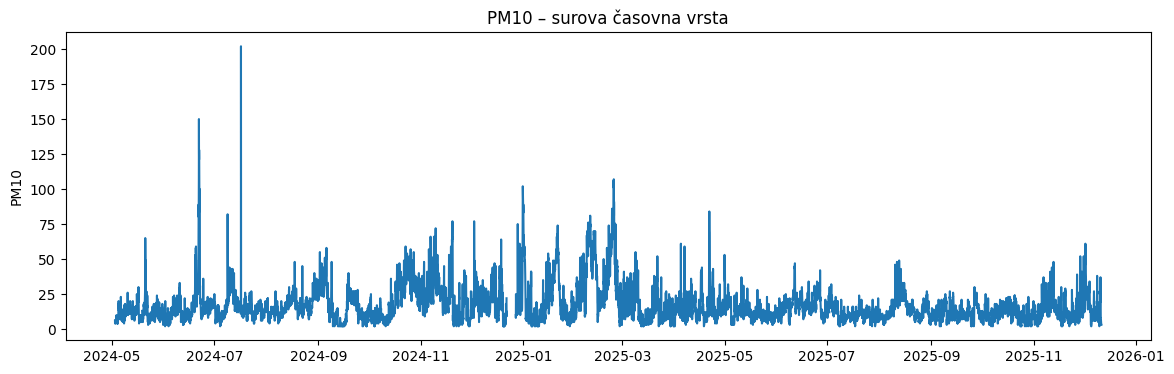

In [17]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df["PM10"])
plt.title("PM10 – surova časovna vrsta")
plt.ylabel("PM10")
plt.show()


In [18]:
df["wind_direction"].value_counts(dropna=False)


,count
wind_direction,
NaN,6932
Z,1607
SZ,1268
S,945
J,940
JV,729
JZ,585
SV,564
V,530


In [19]:
df = df.drop(columns=["wind_direction"])


In [20]:
num_cols = df.select_dtypes(include=["float64", "int64"]).columns

df[num_cols] = df[num_cols].interpolate(method="time")
df[num_cols] = df[num_cols].ffill().bfill()


In [21]:
df.isna().sum()


,0
PM10,0
PM2.5,0
temperature,0
rain,0
pressure,0
precipitation,0
wind_speed,0
clouds,215


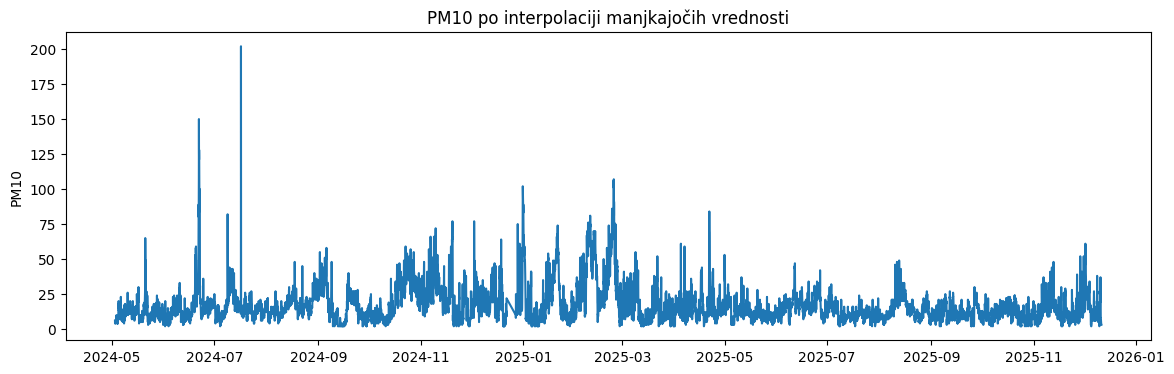

In [22]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df["PM10"])
plt.title("PM10 po interpolaciji manjkajočih vrednosti")
plt.ylabel("PM10")
plt.show()


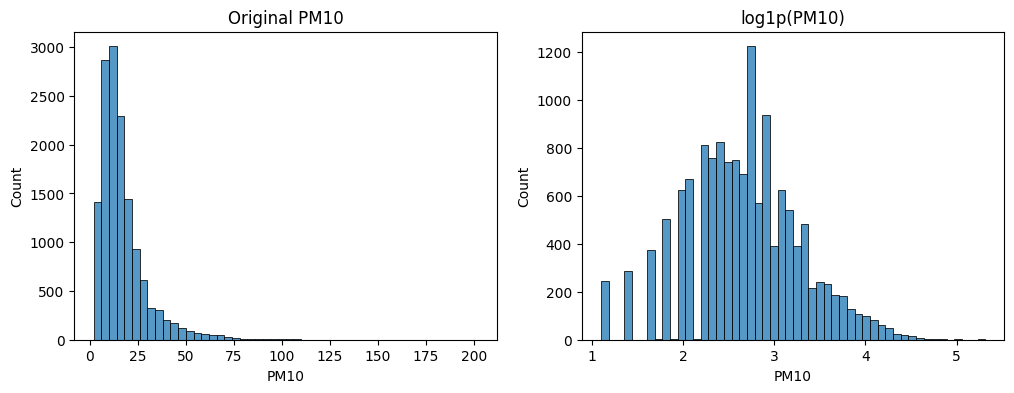

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(df["PM10"], bins=50, ax=ax[0])
ax[0].set_title("Original PM10")

sns.histplot(np.log1p(df["PM10"]), bins=50, ax=ax[1])
ax[1].set_title("log1p(PM10)")

plt.show()


In [24]:
df["PM10_log"] = np.log1p(df["PM10"])


In [26]:
df["clouds"] = df["clouds"].fillna("unknown")
df["clouds"].value_counts()


,count
clouds,
jasno,4555
oblačno,3795
pretežno oblačno,3162
delno oblačno,2373
unknown,215


In [27]:
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)


In [28]:
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

df["dow_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)

df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)


In [29]:
df = df.drop(columns=["hour", "dayofweek", "month"])


In [ ]:

# Časovni split (brez mešanja časov!)


start_date = df.index.min()
split_date = start_date + pd.Timedelta(days=365)

print("Start:", start_date)
print("Split:", split_date)
print("End:  ", df.index.max())


Start: 2024-05-02 20:00:00
Split: 2025-05-02 20:00:00
End:   2025-12-11 07:00:00


In [ ]:

# Razdelitev podatkov na train in test
# Train = prvo leto meritev
# Test  = vse po tem datumu


train_df = df.loc[df.index < split_date].copy()
test_df  = df.loc[df.index >= split_date].copy()

print("Train rows:", len(train_df))
print("Test rows: ", len(test_df))
print("Train period:", train_df.index.min(), "->", train_df.index.max())
print("Test period: ", test_df.index.min(), "->", test_df.index.max())


Train rows: 8760
Test rows:  5340
Train period: 2024-05-02 20:00:00 -> 2025-05-02 19:00:00
Test period:  2025-05-02 20:00:00 -> 2025-12-11 07:00:00


In [ ]:

# Validacijska množica znotraj train 


val_ratio = 0.15
val_size = int(len(train_df) * val_ratio)

train_sub_df = train_df.iloc[:-val_size].copy()
val_df       = train_df.iloc[-val_size:].copy()

print("Train_sub rows:", len(train_sub_df))
print("Val rows:      ", len(val_df))
print("Train_sub period:", train_sub_df.index.min(), "->", train_sub_df.index.max())
print("Val period:      ", val_df.index.min(), "->", val_df.index.max())


Train_sub rows: 7446
Val rows:       1314
Train_sub period: 2024-05-02 20:00:00 -> 2025-03-09 01:00:00
Val period:       2025-03-09 02:00:00 -> 2025-05-02 19:00:00


In [ ]:

# Definicija tarče in vhodnih značilnic

target_col = "PM10_log"

# Numerične značilnice (brez tarče)
numeric_features = [
    "PM2.5", "temperature", "rain", "pressure", "precipitation", "wind_speed",
    "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos",
    "is_weekend"
]


categorical_features = ["clouds"]


for col in numeric_features + categorical_features + [target_col]:
    assert col in df.columns, f"Missing column: {col}"

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 13
Categorical features: 1


In [ ]:

#  Pipeline za transformacijo podatkov


from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [ ]:

# fit na train_sub 
# transformiranje train_sub, val, test.


X_train_sub = preprocessor.fit_transform(train_sub_df)
y_train_sub = train_sub_df[target_col].values

X_val = preprocessor.transform(val_df)
y_val = val_df[target_col].values

X_test = preprocessor.transform(test_df)
y_test = test_df[target_col].values

print("X_train_sub shape:", X_train_sub.shape)
print("X_val shape:      ", X_val.shape)
print("X_test shape:     ", X_test.shape)


X_train_sub shape: (7446, 18)
X_val shape:       (1314, 18)
X_test shape:      (5340, 18)


In [ ]:

# Pretvorba v dense numpy array


def to_dense(x):
    return x.toarray() if hasattr(x, "toarray") else x

X_train_sub_dense = to_dense(X_train_sub)
X_val_dense       = to_dense(X_val)
X_test_dense      = to_dense(X_test)

print("Dense shapes:", X_train_sub_dense.shape, X_val_dense.shape, X_test_dense.shape)


Dense shapes: (7446, 18) (1314, 18) (5340, 18)


In [ ]:

# Funkcija create_sequences
# Za vsak časovni trenutek t vzame okno in napovey(t).

def create_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i, :])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)


In [ ]:

# Velikost okna

window = 72


In [ ]:

# Ustvarimo sekvence

X_train_seq, y_train_seq = create_sequences(X_train_sub_dense, y_train_sub, window)
X_val_seq, y_val_seq     = create_sequences(X_val_dense, y_val, window)
X_test_seq, y_test_seq   = create_sequences(X_test_dense, y_test, window)

print("Train seq:", X_train_seq.shape, y_train_seq.shape)
print("Val seq:  ", X_val_seq.shape, y_val_seq.shape)
print("Test seq: ", X_test_seq.shape, y_test_seq.shape)


Train seq: (7374, 72, 18) (7374,)
Val seq:   (1242, 72, 18) (1242,)
Test seq:  (5268, 72, 18) (5268,)


In [ ]:

# Definicija rekurentnega modela (GRU)


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)
np.random.seed(42)

n_features = X_train_seq.shape[2]

model = keras.Sequential([
    layers.Input(shape=(window, n_features)),
    layers.GRU(64, return_sequences=False),
    layers.Dropout(0.2),
    layers.Dense(1)
])

In [ ]:

# Trening modela



model.compile(optimizer='adam', loss='mse', metrics=['mae'])

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, min_lr=1e-6)
]

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=80,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 3.7008 - mae: 1.5567 - val_loss: 0.2340 - val_mae: 0.3905 - learning_rate: 0.0010
Epoch 2/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.2012 - mae: 0.3549 - val_loss: 0.2027 - val_mae: 0.3608 - learning_rate: 0.0010
Epoch 3/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1771 - mae: 0.3257 - val_loss: 0.1945 - val_mae: 0.3490 - learning_rate: 0.0010
Epoch 4/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.1551 - mae: 0.3075 - val_loss: 0.1722 - val_mae: 0.3265 - learning_rate: 0.0010
Epoch 5/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.1423 - mae: 0.2934 - val_loss: 0.1647 - val_mae: 0.3170 - learning_rate: 0.0010
Epoch 6/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.1347 - mae: 0.2872 - val_loss: 0.1744 - val_mae: 0.3288 - learning_rate: 0.0010
Epoch 7/80
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1222 - mae: 0.2726 - val_loss: 0.1518 - val_mae: 0.3065 - learning_rate: 0.001

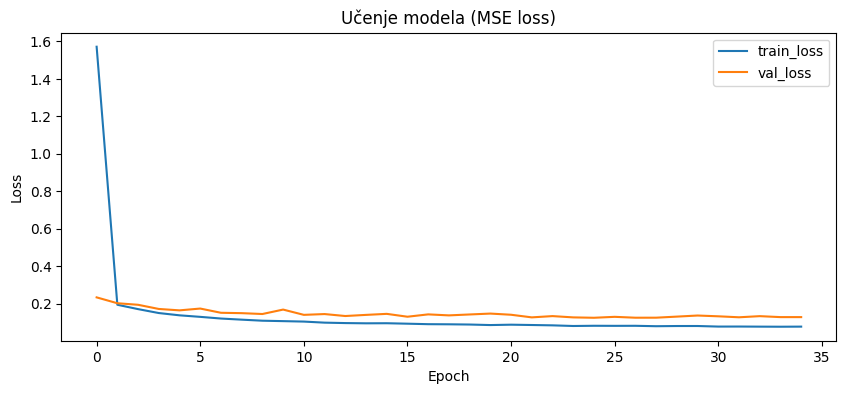

In [ ]:

#  Graf učenja (train vs val loss)


plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Učenje modela (MSE loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:

# Napoved na testni množici


y_test_pred_log = model.predict(X_test_seq).squeeze()

print("Predictions shape:", y_test_pred_log.shape)


165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
Predictions shape: (5268,)


In [ ]:

# Inverzna transformacija


y_test_true_pm10 = np.expm1(y_test_seq)
y_test_pred_pm10 = np.expm1(y_test_pred_log)


In [ ]:

# Izračun regresijskih metrik


from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

mae = mean_absolute_error(y_test_true_pm10, y_test_pred_pm10)
mse = mean_squared_error(y_test_true_pm10, y_test_pred_pm10)
evs = explained_variance_score(y_test_true_pm10, y_test_pred_pm10)


epsilon = 1e-6
mape = np.mean(
    np.abs((y_test_true_pm10 - y_test_pred_pm10) / (y_test_true_pm10 + epsilon))
) * 100

print(f"MAE  : {mae:.3f}")
print(f"MAPE : {mape:.2f} %")
print(f"MSE  : {mse:.3f}")
print(f"EVS  : {evs:.3f}")


MAE  : 2.398
MAPE : 22.64 %
MSE  : 12.204
EVS  : 0.750


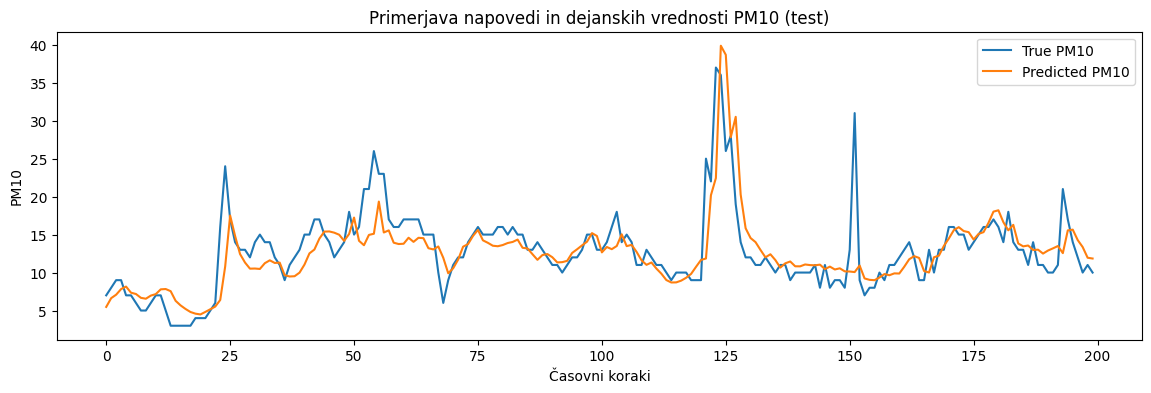

In [ ]:

# primerjava napovedi in dejanskih vrednosti


n_plot = 200  # število točk za prikaz

plt.figure(figsize=(14,4))
plt.plot(y_test_true_pm10[:n_plot], label="True PM10")
plt.plot(y_test_pred_pm10[:n_plot], label="Predicted PM10")
plt.title("Primerjava napovedi in dejanskih vrednosti PM10 (test)")
plt.xlabel("Časovni koraki")
plt.ylabel("PM10")
plt.legend()
plt.show()


In [ ]:

# Organizacija izhodnih datotek

import os
import joblib

os.makedirs("artifacts", exist_ok=True)


In [ ]:

# Shranjevanje modela


model.save("artifacts/pm10_gru_model.keras")
print("Saved model to artifacts/pm10_gru_model.keras")


Saved model to artifacts/pm10_gru_model.keras


In [ ]:

# Shranjevanje preprocessorja


joblib.dump(preprocessor, "artifacts/preprocessor.joblib")
print("Saved preprocessor to artifacts/preprocessor.joblib")


Saved preprocessor to artifacts/preprocessor.joblib


In [ ]:

# Shranimo  konfiguracijo

config = {
    "window": int(window),
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "target_col": target_col
}

joblib.dump(config, "artifacts/config.joblib")
print("Saved config to artifacts/config.joblib")


Saved config to artifacts/config.joblib


In [ ]:

# validacija nalaganja


loaded_model = keras.models.load_model("artifacts/pm10_gru_model.keras")
loaded_preprocessor = joblib.load("artifacts/preprocessor.joblib")
loaded_config = joblib.load("artifacts/config.joblib")

print("Loaded OK. window =", loaded_config["window"])


Loaded OK. window = 72
